L'idea è quella di valutare la differenza di tempo di running fra gpu colab e jupyter notebook sullo stesso file!

In [1]:
!git clone https://github.com/hltfbk/E3C-Corpus.git

Cloning into 'E3C-Corpus'...
remote: Enumerating objects: 56266, done.
remote: Counting objects: 100% (6146/6146), done.
remote: Compressing objects: 100% (702/702), done.
remote: Total 56266 (delta 5444), reused 6062 (delta 5403), pack-reused 50120
Receiving objects: 100% (56266/56266), 184.87 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (12874/12874), done.
Updating files: 100% (51356/51356), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import pandas as pd
import os
from tqdm.notebook import tqdm
DIR = "E3C-Corpus/data_collection/Italian/layer3"

# Elenco dei file nella directory
data_files = os.listdir(DIR)

In [4]:
dfs = []
for filename in tqdm(os.listdir(DIR)):
    authors_string = False
    authors_dict = False
    f = os.path.join(DIR, filename)
    if os.path.isfile(f):
      with open(f, 'r', encoding='utf-8') as fp: # QUESTA è LA RIGA MODIFICATA, VEDI CODICE ORIGINALE VITTORIO PER CAPIRE, QUESTA MODIFICA è STATA NECESSARIA ALTRIMENTI MI DAVA ERRORE (SU COLLAB NO)
        d = json.load(fp)
      if d['authors'] == []:
        d['authors'] = ''
        i = [0]
      elif isinstance(d['authors'], str): #for some Spanish documents (es ES102568.json)
        authors_string = True
        i = [0]
      elif isinstance(d['authors'], dict): #for Basque
        authors_dict = True
        i = [0]
      else:
        i = list(range(len(d['authors'])))
      data = pd.DataFrame(d, index=i)
      if d['authors'] != '':
        try:
          data.authors = pd.DataFrame(data.authors.values.tolist())['author']
        except: #spanish has different format
          if authors_dict:
            data.authors = d['authors']['author']
          elif not authors_string:
            data.authors = pd.DataFrame(data.authors.values.tolist())[1]
        cols = list(data.columns) # columns are different in different languages
        cols.remove('authors')
        data = data.groupby(cols)['authors'].apply(','.join).reset_index()
      dfs.append(data) # append the data frame to the list
df = pd.concat(dfs, ignore_index=True, axis=0) # concatenate all the data frames in the list.

  0%|          | 0/10213 [00:00<?, ?it/s]

Ci ha impiegato 16 sec (12 secondi contro i 41 di jupyter)

In [5]:
import nltk
nltk.download('punkt')
def filter_words(sentence):
    return [word for word in nltk.word_tokenize(sentence) if word.isalnum()]

def tokenize(text):
    return [filter_words(sentence) for sentence in nltk.sent_tokenize(text.lower())]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:

documents = []
for i in range(len(df)):
    text = df.loc[i,'text']
    documents.append(text)

sentences = []
for doc in documents:
    sentences.extend(tokenize(doc))

In [ ]:
#sentences
#documents

oss ora faccio un modello più complesso con dimensionalità del vettore = 5 e window size = 5

In [7]:
import gensim
# create the model and tune it!
word2Vec_model = gensim.models.Word2Vec(
                    sentences, # input sentences
                    sg=0, # use skip grams (0=CBOW). skip grams tend to work better on smaller corpora
                    vector_size=5, # this is how many dimensions the vectors will be
                    min_count=1, # how many times must a word apper
                    window=5
                    )

# Let's save the model to file!
word2Vec_model.save('my_vecs.p')

# let's take a look at some of the methods you can use:
# most similar
#print(word2Vec_model.wv.most_similar('government'))

# calculate similarity (cosine similarity)
# distance will calculate euclidean distance
#print(word2Vec_model.wv.similarity('government', 'president'))

In [9]:
#word2Vec_model.save('my_vecs.p')
print(word2Vec_model.wv.most_similar('cane'))

[('coniglio', 0.9968106150627136), ('tmaxmediano', 0.9936492443084717), ('urinario', 0.992950439453125), ('bassi', 0.9902007579803467), ('bassissima', 0.9859026074409485), ('elenco', 0.9852061867713928), ('octenilsuccinato', 0.985025942325592), ('diversi', 0.9846609830856323), ('ratto', 0.9843584895133972), ('impotence', 0.9838393926620483)]


In [10]:
print(word2Vec_model.wv.most_similar_cosmul('uccello'))

[('micronucleare', 0.994989275932312), ('pt3apn0', 0.9943224191665649), ('vasodilazione', 0.993867039680481), ('utilizzate', 0.9935799837112427), ('triventricolare', 0.9933344125747681), ('cuneiforme', 0.9932193756103516), ('lipemico', 0.991963803768158), ('menorragie', 0.9912405610084534), ('antitrichomonas', 0.9904098510742188), ('usate', 0.9900234937667847)]


In [12]:
print(word2Vec_model.wv.similarity('uccello', 'cane'))

0.5821518


In [36]:
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA non uso ora pca perchè ho dimensionalità gia uguale a due

#my_model = gensim.models.Word2Vec.load('my_vecs.p') non mi serve caricarlo

word_names = word2Vec_model.wv.index_to_key
word_vectors = [word2Vec_model.wv[word] for word in word_names]

#pca = PCA(n_components=2)

#my_pca = pca.fit_transform(my_model[model_vocab])
#vettori = word2Vec_model[model_vocab]
word_names

['di',
 'e',
 'la',
 'in',
 'con',
 'a',
 'per',
 'è',
 'al',
 'del',
 'non',
 'il',
 'essere',
 'o',
 'della',
 'pazienti',
 'un',
 'dose',
 'da',
 'i',
 'mg',
 'sono',
 'una',
 'trattamento',
 'deve',
 'che',
 'farmaco',
 'può',
 'si',
 'ad',
 'nei',
 'vedere',
 'le',
 'compressa',
 'paragrafo',
 'gravidanza',
 'giorno',
 'sito',
 'completa',
 'effetti',
 'vedi',
 'tecnica',
 'alla',
 'rcp',
 'scheda',
 'degli',
 'accedi',
 'farmaci',
 'sulla',
 'somministrazione',
 'altri',
 'medicinali',
 'durante',
 'base',
 'prescrizione',
 'compresse',
 'come',
 'attivo',
 'sovradosaggio',
 'dopo',
 'delle',
 'nel',
 'dati',
 'principio',
 'se',
 'renale',
 'dei',
 'terapia',
 'prima',
 'studi',
 'devono',
 'dosi',
 'soggetti',
 'più',
 'anni',
 'interazioni',
 '2',
 'bambini',
 'caso',
 'sicurezza',
 'prendere',
 'paziente',
 'macchinari',
 'soluzione',
 'posologia',
 'possono',
 '1',
 'proprietà',
 'medica',
 'capacità',
 'guidare',
 'gli',
 'su',
 'ed',
 'equivalenti',
 'sia',
 'italia',
 'du

In [14]:
word_vectors # tutte le parole con l'embedding numerico 2d.

[array([ 1.0771766,  1.5184859, -2.472076 ,  1.1912882, -1.0702913],
       dtype=float32),
 array([ 1.8733588,  2.0073874,  0.6063617,  1.7650927, -1.6514002],
       dtype=float32),
 array([ 2.6551337 ,  0.63876635, -5.359964  ,  3.252958  ,  1.1884948 ],
       dtype=float32),
 array([ 3.0652268 ,  2.280537  , -2.540184  ,  3.7274196 , -0.98088485],
       dtype=float32),
 array([ 1.5514052 ,  2.4660852 ,  0.79941905,  2.910274  , -0.69878525],
       dtype=float32),
 array([-0.83256  ,  2.8405647, -2.8171983,  1.4993709, -0.857447 ],
       dtype=float32),
 array([ 0.6566856,  2.5713258, -3.718589 ,  2.3699763, -0.8811726],
       dtype=float32),
 array([ 0.5297021,  2.678681 , -2.4230804,  3.6734293,  0.6583737],
       dtype=float32),
 array([-2.0021372,  0.401365 , -4.2415657, -1.8086905,  0.1008945],
       dtype=float32),
 array([ 1.2374593 , -1.1479436 , -5.457172  , -1.8495394 , -0.45564967],
       dtype=float32),
 array([ 4.7784305 ,  0.33264965, -3.3423998 ,  3.1636643 , 

In [16]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [25]:
word_vectors = np.array(word_vectors) # necessario siano np array per fare tsne
word_vectors

array([[ 1.0771766e+00,  1.5184859e+00, -2.4720759e+00,  1.1912882e+00,
        -1.0702913e+00],
       [ 1.8733588e+00,  2.0073874e+00,  6.0636169e-01,  1.7650927e+00,
        -1.6514002e+00],
       [ 2.6551337e+00,  6.3876635e-01, -5.3599639e+00,  3.2529581e+00,
         1.1884948e+00],
       ...,
       [ 1.6725680e-01,  3.0850825e-01, -3.3870742e-02, -2.3004088e-01,
         1.5898209e-02],
       [-1.5536920e-02, -6.4479820e-02,  1.5990198e-01,  7.2789460e-02,
         2.0659272e-01],
       [ 1.8423322e-01,  9.0554118e-02,  2.4694665e-01, -5.5243060e-02,
        -1.6114332e-03]], dtype=float32)

In [26]:
tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
coordinates = tsne_model.fit_transform(word_vectors)

ci ha messo quasi 10 min a fare tsne del modello con parole di dim = 5

In [47]:
# per rendere leggibile il plot, printo solo le prime 100 parole di word names:
word_names_reduced = word_names[200:230]

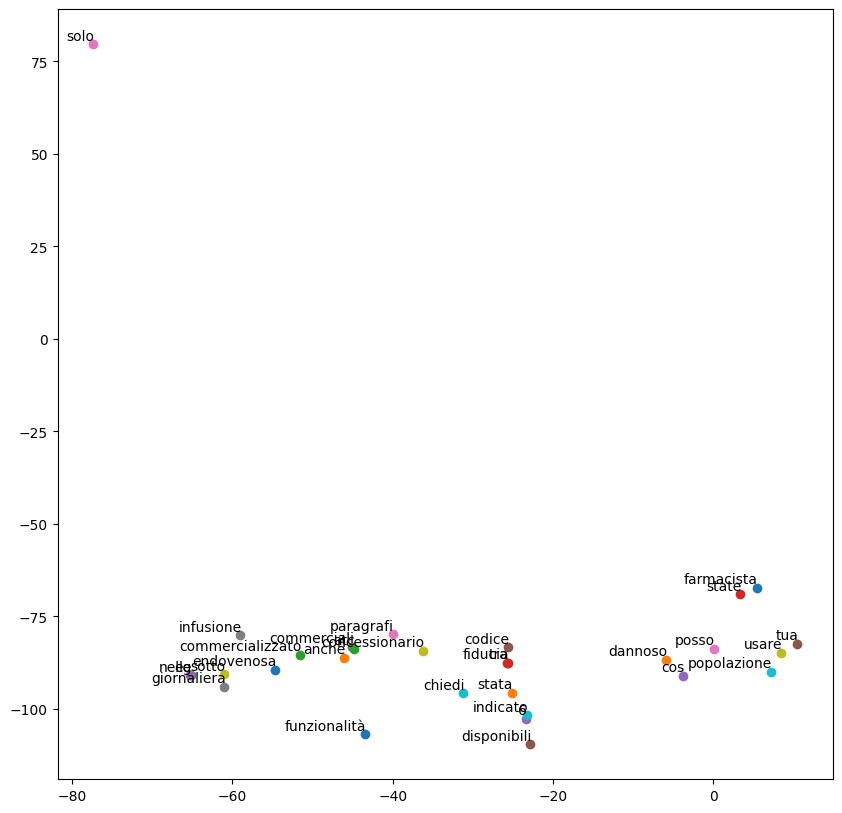

In [48]:
x = []
y = []
for i, word in enumerate(word_names_reduced):
    X,Y = coordinates[i]
    x.append(X)
    y.append(Y)

plt.figure(figsize=(10,10))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(word_names_reduced[i],
                 xy=(x[i], y[i]),
                 xytext=(1, 1),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()